# Hierarchical Feature Visualization in a Jupyter Notebook

## Load a Pre-trained CNN Model.
Load a pre-trained CNN model (e.g., VGG16, ResNet50, Inception) using a deep learning framework like Keras or PyTorch.

The CNN Model: VGG16

[VGG16 architecture](https://arxiv.org/abs/1409.1556) consists of 13 consecutive 3x3 convolution layers with max poolings in between, followed by 3 fully connected layers. We are interested in examining input patterns that excite the neurons in different convolutional layers. 

<figure>
<img src="vgg16.png"
     alt="VGG16 architecture"
     style="float: left; margin-right: 5px;"
     height="500px" />
<figcaption>VGG16 architecture</figcaption>

</figure>

We can import a VGG16 model, pretrained on [ImageNet dataset](http://www.image-net.org/), using tensorflow.

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load a pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

## Define a Visualization Model.
Create a new model that takes an input image and outputs the feature maps (activations) from selected intermediate layers. This allows you to inspect the features learned by each layer.

In [3]:
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]
layer_outputs = [model.get_layer(name).output for name in layer_names]
visualization_model = Model(inputs=model.input, outputs=layer_outputs)

## Prepare an Input Image.
Load and preprocess an image for which you want to visualize the features. This typically involves resizing, normalizing, and expanding dimensions to match the model's input requirements.

In [4]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'coconut.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# Use canonical preprocessing for VGG16 to improve stability/contrast
img_array = preprocess_input(img_array)

Show the image

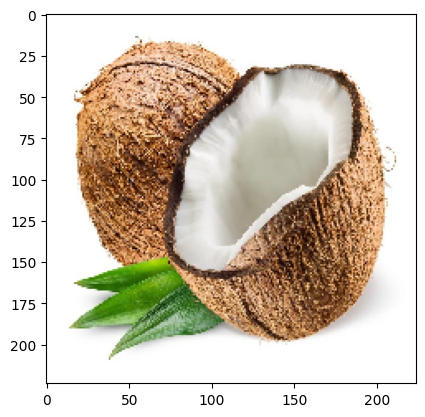

In [7]:
import matplotlib
matplotlib.pyplot.imshow(img)
matplotlib.pyplot.show()

## Obtain Feature Maps.
Pass the preprocessed image through the visualization_model to get the feature maps for each selected layer.

In [8]:
feature_maps = visualization_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


## Visualize Feature Maps.
Iterate through the obtained feature maps and plot them. You can visualize individual feature maps or a selection of them to observe the patterns and activations learned at different hierarchical levels.

In [24]:
print(len(layer_names))
print(len(feature_maps))

18
18


In [10]:
print(layer_names[0])

block1_conv1


In [38]:
print(feature_maps[17][0].shape)

(7, 7, 512)


In [ ]:
# visualize all the feature maps in the first layer 


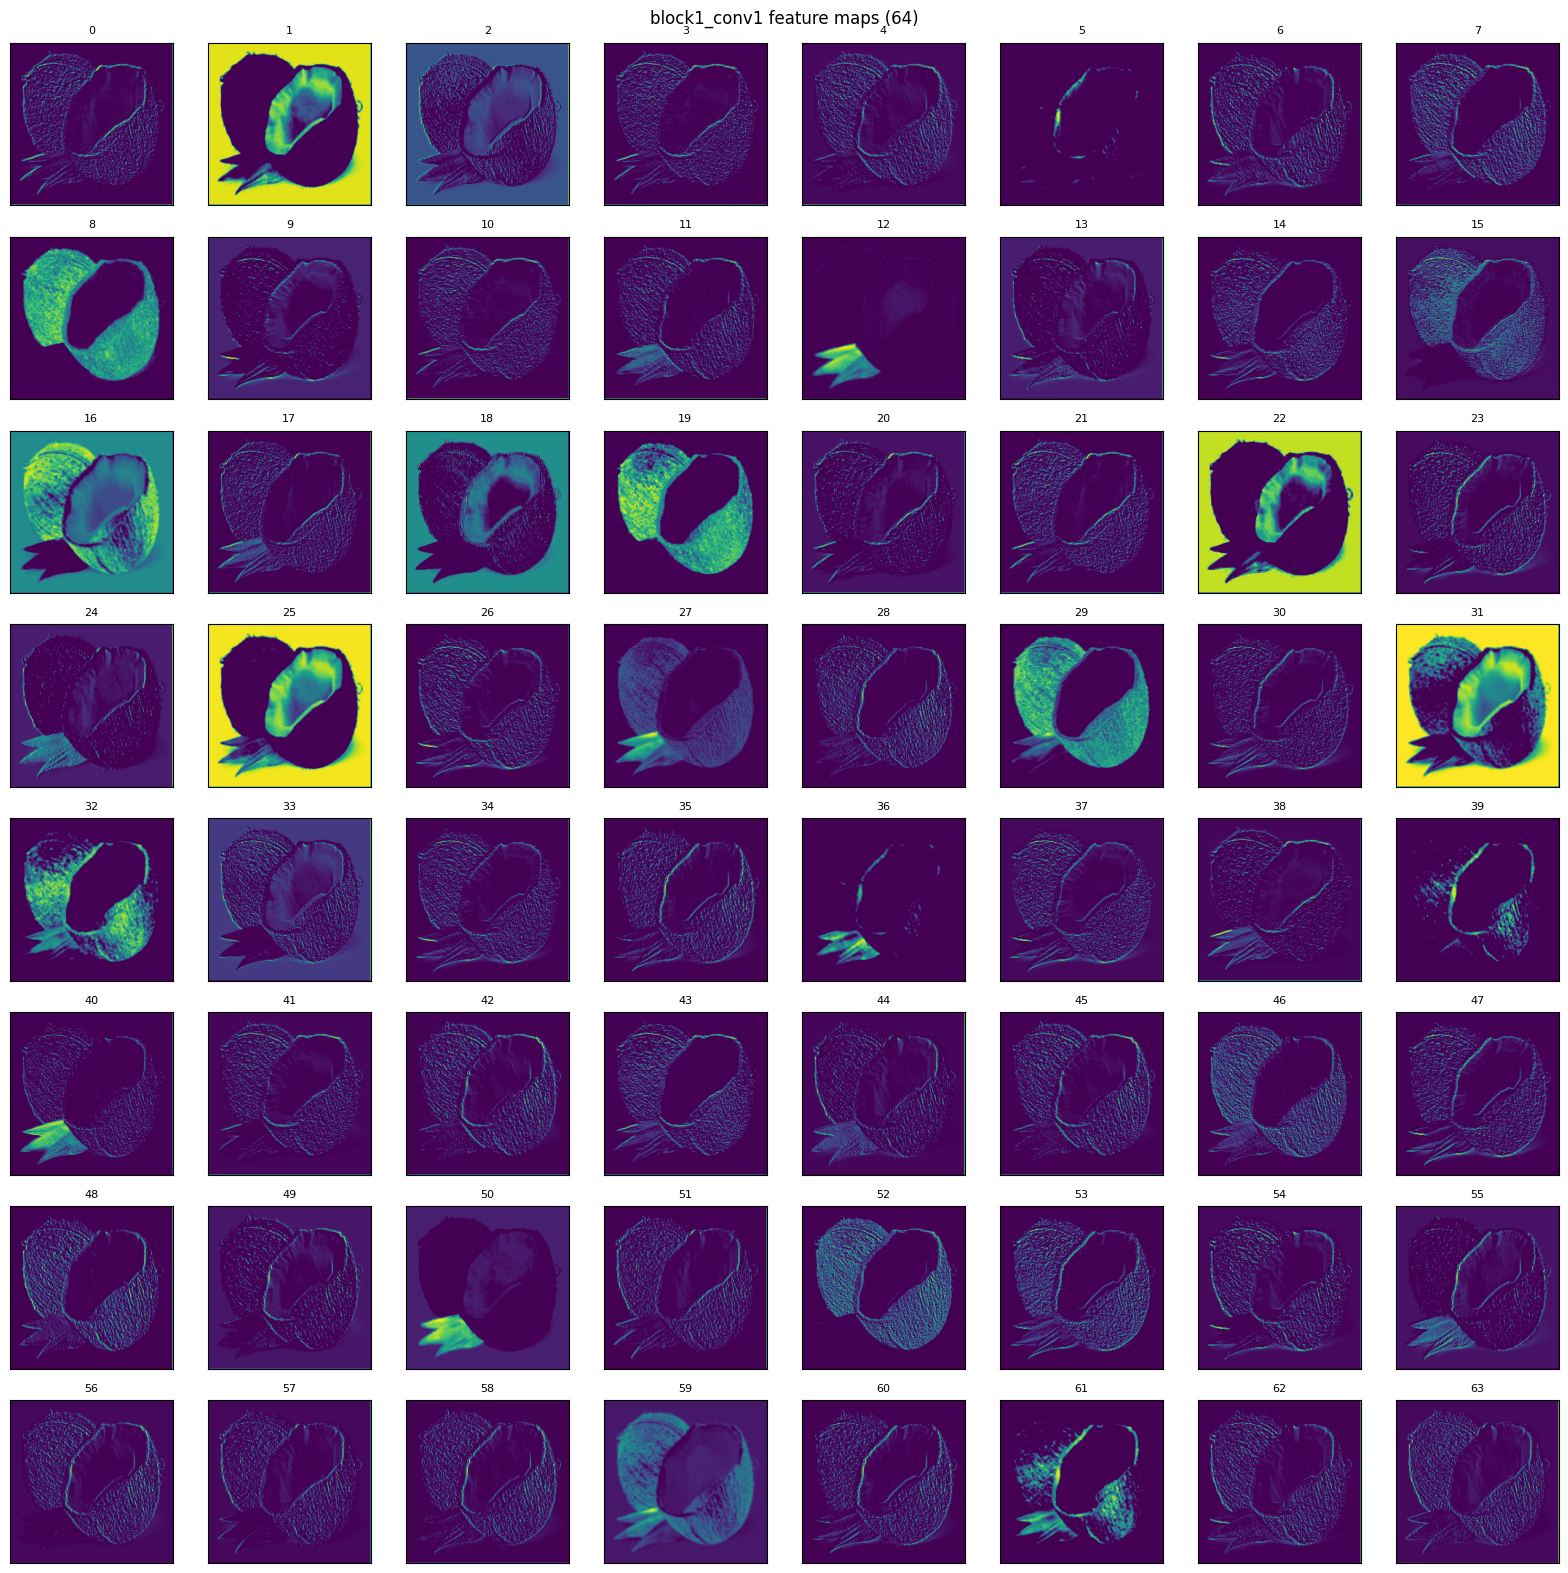

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize all feature maps from the first layer (e.g., block1_conv1)
fm = feature_maps[0][0]  # shape: (H, W, C)
num_features = fm.shape[-1]
cols = min(8, num_features)
rows = int(np.ceil(num_features / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = np.atleast_2d(axes)

for i in range(num_features):
    r, c = divmod(i, cols)
    x = fm[:, :, i]
    std = x.std()
    if std < 1e-6:
        xn = np.zeros_like(x)
    else:
        xn = (x - x.mean()) / (std + 1e-8)
        xn = (xn - xn.min()) / (xn.max() - xn.min() + 1e-8)
    axes[r, c].imshow(xn, cmap='viridis')
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])
    axes[r, c].set_title(str(i), fontsize=8)

# Hide any unused subplots
for j in range(num_features, rows * cols):
    r, c = divmod(j, cols)
    axes[r, c].axis('off')

fig.suptitle(f"{layer_names[0]} feature maps ({num_features})", fontsize=12)
plt.tight_layout()
plt.show()

## Visualize Filters in the Block1_Conv1 and Block5_Conv3

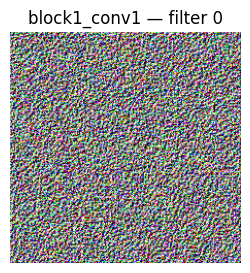

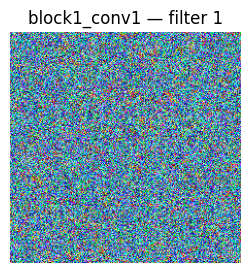

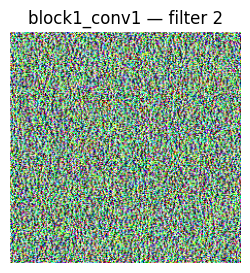

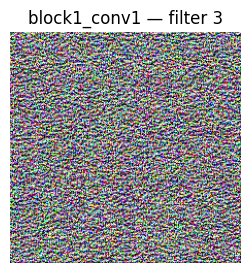

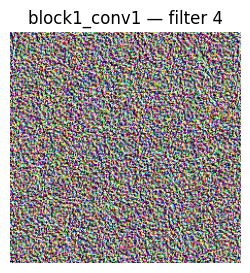

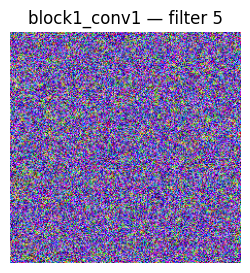

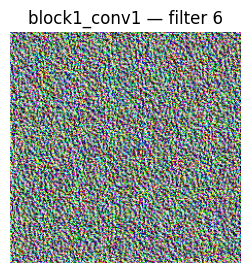

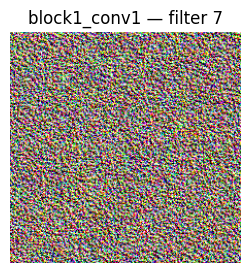

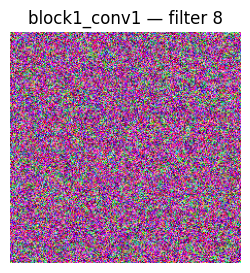

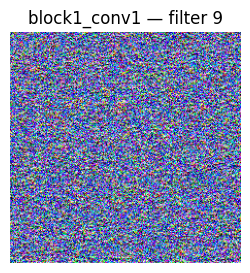

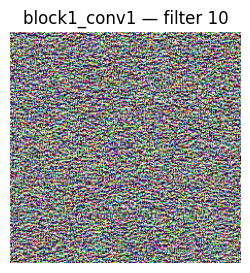

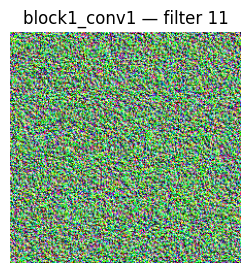

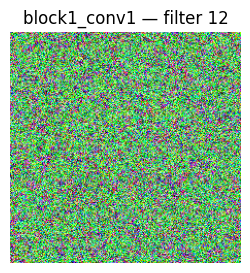

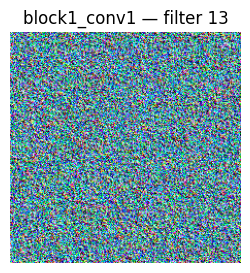

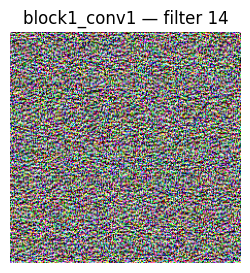

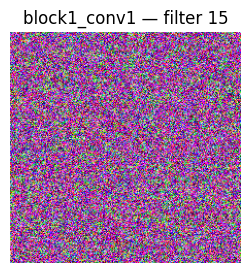

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Utility to convert a preprocessed image tensor back to displayable RGB uint8
def deprocess_image(x: tf.Tensor) -> np.ndarray:
    x = x[0].numpy()
    # BGR mean values used in VGG16 preprocessing
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # Convert BGR to RGB
    x = x[..., ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Perform gradient ascent on the input image to maximize a given filter's activation
def visualize_filter(layer_name: str, filter_index: int, steps: int = 30, step_size: float = 1.0, img_size: int = 224) -> np.ndarray:
    submodel = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    # Start from random noise in pixel space, then preprocess to VGG16 space
    init_img = tf.random.uniform((1, img_size, img_size, 3), minval=0.0, maxval=255.0)
    img = preprocess_input(init_img)
    img = tf.Variable(img)

    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            activation = submodel(img)
            loss = tf.reduce_mean(activation[:, :, :, filter_index])
        grads = tape.gradient(loss, img)
        # Normalize gradients for stable updates
        grads = grads / (tf.math.reduce_std(grads) + 1e-8)
        img.assign_add(step_size * grads)

    return deprocess_image(img)

# Visualize filters for specified layers; set max_filters_per_layer=None to run all
layers_to_visualize = ['block1_conv1']
max_filters_per_layer = 16  # e.g., set to 16 to limit

for layer_name in layers_to_visualize:
    num_filters = int(model.get_layer(layer_name).output.shape[-1])
    count = num_filters if max_filters_per_layer is None else min(num_filters, max_filters_per_layer)
    for i in range(count):
        img = visualize_filter(layer_name, i, steps=30, step_size=1.0, img_size=224)
        plt.figure(figsize=(3, 3))
        plt.title(f"{layer_name} — filter {i}")
        plt.imshow(img)
        plt.axis('off')
        plt.show()


plot each channel (3x3) for each filter in block5_conv3.

In [40]:
print(layer_names)

['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


block1_conv1 kernel weights shape: (3, 3, 3, 64) -> (kh, kw, Cin, Cout)


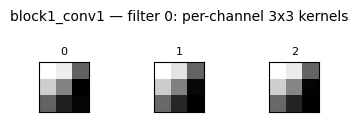

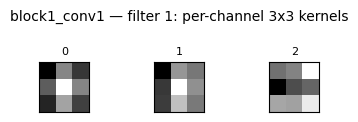

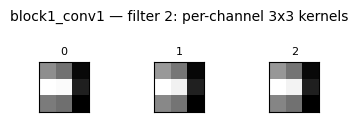

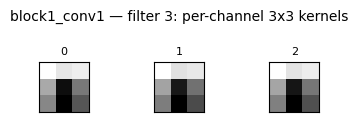

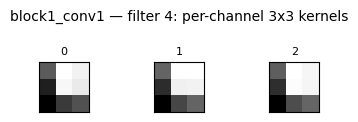

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize per-channel 3x3 kernels for each filter in block5_conv3
# NOTE: block5_conv3 has shape (3, 3, 512, 512) => 512 filters, each with 512 input channels
# Plotting all channels for all filters would create 262,144 tiles.
# Use the selectors below to limit for practicality.

layer_name = 'block1_conv1'
w = model.get_layer(layer_name).get_weights()[0]  # (3, 3, Cin, Cout)
kh, kw, cin, cout = w.shape
print(f"{layer_name} kernel weights shape: {w.shape} -> (kh, kw, Cin, Cout)")

# Select which filters (output channels) and input channels to display
# Adjust these as needed. To show all channels for a single filter, set channels_to_plot = range(cin)
filters_to_plot = list(range(0, min(5, cout)))        # e.g., first 2 filters
channels_to_plot = list(range(0, min(16, cin)))       # e.g., first 16 input channels

for f_idx in filters_to_plot:
    num_channels = len(channels_to_plot)
    cols = min(8, num_channels)
    rows = int(np.ceil(num_channels / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2))
    axes = np.atleast_2d(axes)
    fig.suptitle(f"{layer_name} — filter {f_idx}: per-channel 3x3 kernels", fontsize=10)

    for i, c_idx in enumerate(channels_to_plot):
        r, c = divmod(i, cols)
        k = w[:, :, c_idx, f_idx]  # (3, 3)
        # Normalize per-channel for visualization
        k_min, k_max = k.min(), k.max()
        k_norm = (k - k_min) / (k_max - k_min + 1e-8)
        axes[r, c].imshow(k_norm, cmap='gray', vmin=0.0, vmax=1.0, interpolation='nearest')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        axes[r, c].set_title(str(c_idx), fontsize=8)

    # Hide any unused subplots
    for j in range(num_channels, rows * cols):
        r, c = divmod(j, cols)
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


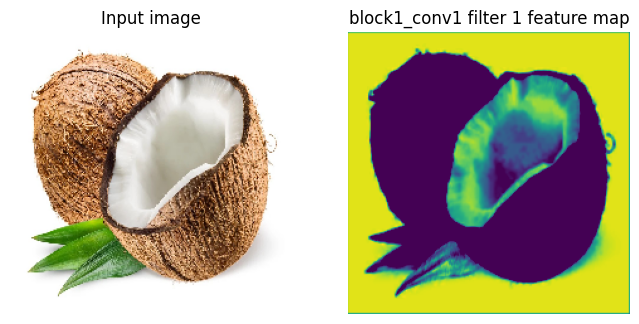

In [48]:
# Plot the corresponding feature map (activation) for a given layer/filter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

layer_name = 'block1_conv1'   # change as needed
filter_idx = 1               # change as needed

submodel = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
activation = submodel.predict(img_array)  # (1, H, W, C)
fm = activation[0, :, :, filter_idx]

# Normalize for display
fm_n = (fm - fm.min()) / (fm.max() - fm.min() + 1e-8)

# Upsample to input size for side-by-side view
resized = tf.image.resize(fm_n[..., None], (img.size[1], img.size[0]), method='bilinear').numpy().squeeze()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'{layer_name} filter {filter_idx} feature map')
plt.imshow(resized, cmap='viridis')
plt.axis('off')
plt.show()


<img src="convolution.png"
     style="float: left; margin-right: 5px;"
     height="400px" />

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Manual vs Keras activation MAE for block1_conv1 filter 1: 0.000001


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

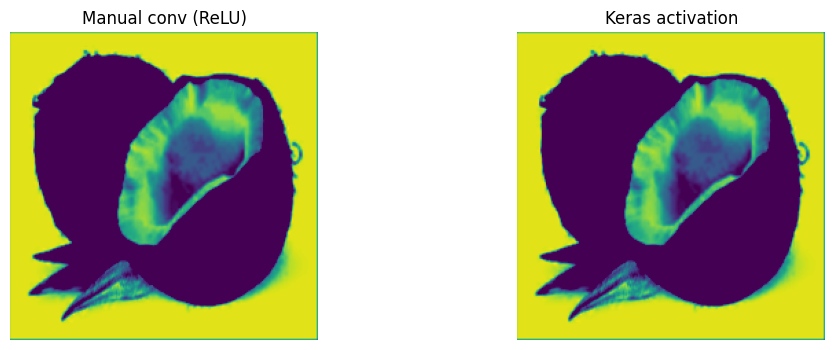

In [53]:
# Low-level convolution: manually apply a single conv filter via dot products
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

layer_name = 'block1_conv1'
filter_idx = 1  # change to visualize another filter

# Get weights and bias: (kh, kw, Cin, Cout), (Cout,)
W, b = model.get_layer(layer_name).get_weights()
kh, kw, Cin, Cout = W.shape
assert kh == 3 and kw == 3, "This demo assumes 3x3 kernels."

kernel = W[:, :, :, filter_idx]      # (3, 3, Cin)
bias = b[filter_idx]

# Use the same preprocessed image that the model sees
x = img_array[0]                      # (H, W, Cin)
H, Wd, _ = x.shape

# Zero-padding for 'same' convolution
pad = kh // 2
x_pad = np.pad(x, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

# Manual convolution with stride=1, padding='same'
manual_act = np.zeros((H, Wd), dtype=np.float32)
for i in range(H):
    for j in range(Wd):
        patch = x_pad[i:i+kh, j:j+kw, :]            # (3, 3, Cin)
        manual_act[i, j] = np.sum(patch * kernel) + bias

# Apply ReLU (layer activation)
manual_act = np.maximum(0.0, manual_act)

# Reference from Keras submodel
sub = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
ref_act = sub.predict(img_array)[0, :, :, filter_idx]

# Compare
mae = np.mean(np.abs(manual_act - ref_act))
print(f"Manual vs Keras activation MAE for {layer_name} filter {filter_idx}: {mae:.6f}")

# Normalize for display
show_manual = (manual_act - manual_act.min()) / (manual_act.max() - manual_act.min() + 1e-8)
show_ref = (ref_act - ref_act.min()) / (ref_act.max() - ref_act.min() + 1e-8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Manual conv (ReLU)')
plt.imshow(show_manual, cmap='viridis')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Keras activation')
plt.imshow(show_ref, cmap='viridis')
plt.axis('off')

